In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)
import matplotlib.pyplot as plt

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cuda:2


In [29]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
            
        self.beta = Parameter(0.25*torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True

    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
            
        a = self.linears[-1](a) 
         
        return a  
    
    
    def loss(self,x_coll,f_hat):
            g = x_coll.clone()             
            g.requires_grad = True
  
            u = self.forward(g) 

            u_x = autograd.grad(u,g,torch.ones([x.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
            
            du_dx = u_x[:,[0]]
            
            
            f = du_dx - 8*torch.cos(8*x)
            
            x_train = torch.zeros((1,1)).float().to(device)
            u_train = torch.ones((1,1)).float().to(device)
            
            return self.loss_function(f,f_hat) + self.loss_function(self.forward(x_train),u_train) 

In [30]:
x = torch.from_numpy(np.linspace(-5,5,100).reshape(-1,1)).float().to(device)
ub = np.array([5.0])
lb = np.array([-5.0])

x_coll = x
f_hat = torch.zeros((100,1),device= device)

layers = np.array([1,50,1]) #9 hidden layers

torch.manual_seed(124)
PINN = Sequentialmodel(layers)
PINN.to(device)

optimizer = optim.LBFGS(PINN.parameters(), lr=0.1)

def closure():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = PINN.loss(x_coll,f_hat)
    loss.backward() #backprop
    
    return loss

for i in range(100):
        
    optimizer.step(closure)
    
    if(i%1==0):
        loss_np = PINN.loss(x_coll,f_hat).cpu().detach().numpy()
        print(i,"Train Loss",loss_np)
loss_np = PINN.loss(x_coll,f_hat).cpu().detach().numpy()
print(i,"Train Loss",loss_np)

0 Train Loss 31.662067
1 Train Loss 31.655144
2 Train Loss 31.65444
3 Train Loss 31.644588
4 Train Loss 31.640942
5 Train Loss 31.637178
6 Train Loss 31.634623
7 Train Loss 31.633139
8 Train Loss 31.632254
9 Train Loss 31.631413
10 Train Loss 31.630833
11 Train Loss 31.619728
12 Train Loss 31.613157
13 Train Loss 31.607994
14 Train Loss 31.604982
15 Train Loss 31.60494
16 Train Loss 31.604937
17 Train Loss 31.60493
18 Train Loss 31.60493
19 Train Loss 31.60493
20 Train Loss 31.604925
21 Train Loss 31.604925
22 Train Loss 31.604925
23 Train Loss 31.604923
24 Train Loss 31.604921
25 Train Loss 31.60492
26 Train Loss 31.604916
27 Train Loss 31.604912
28 Train Loss 31.604723
29 Train Loss 31.604475
30 Train Loss 31.60447
31 Train Loss 31.604452
32 Train Loss 31.604437
33 Train Loss 31.604322
34 Train Loss 31.604101
35 Train Loss 31.60309
36 Train Loss 31.602001
37 Train Loss 31.59964
38 Train Loss 31.599043
39 Train Loss 31.595652
40 Train Loss 31.594046
41 Train Loss 31.593517
42 Train Lo

3.9497705


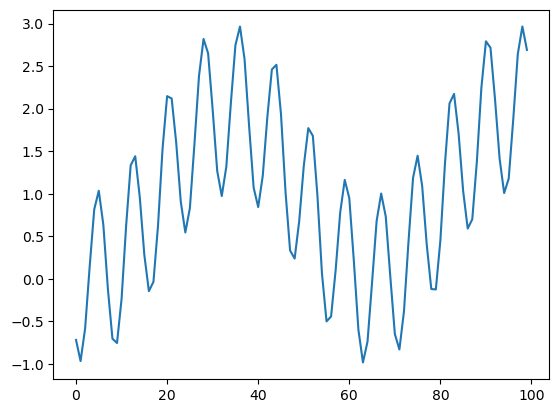

In [31]:
u_pred = PINN.forward(x).cpu().detach().numpy()
diff = u_pred - torch.sin(x).cpu().detach().numpy()
print(np.max(diff) - np.min(diff))
plt.plot(diff)

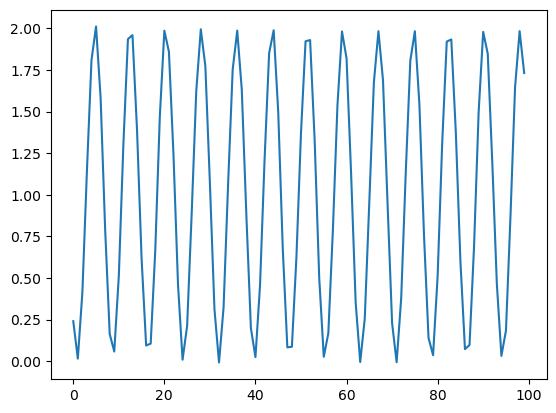

In [32]:
plt.plot(u_pred)

In [6]:
u_pred[50]

array([1.311129], dtype=float32)

NameError: name 'reps' is not defined

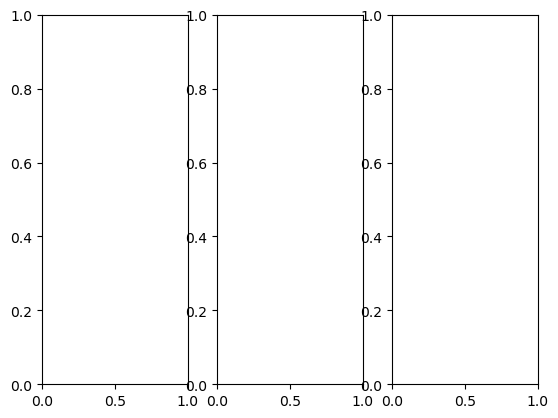

In [7]:
fig, ax = plt.subplots(1,3)

plt_data = [np.transpose(np.abs(u_pred))/reps,np.transpose(np.abs(u_x_pred))/reps,np.transpose(np.abs(u_xx_pred))/reps]

for i in range(3):
    ax[i].boxplot(plt_data[i],0,'')
    ax[i].figure.set_size_inches(10,2.5)
    
    ax[i].set_ylim([-0.0001,0.0005])
    
    # ax[i].set_yscale('log')
    ax[i].tick_params(axis='y', labelsize=8)

In [ ]:
u_pred.shape